# Logistic Regression: Step-by-Step

This notebook will guide you to make a logistic regression. Don't let the regression word fool you, as this is actually a classification technique used in Machine Learning. By the end of this notebook, you will be able to make your own classifier from multiple input variables.

The biggest different between regression and classification technique is, regression predicts value, while classification predicts label. For example, given a student's exam score, homework score, and attendance, the model should be able to determine whether the student PASS or FAIL the course. In this example, there are 3 variable: exam score ($x_0$), homework score ($x_1$), and attendance ($x_2$), and the label to predict is a boolean value, TRUE/FALSE, PASS/FAIL.

Logistic regression is one of the supervised Machine Learning algorithm, which means, given input data & target data, the algorithm will ~~magically~~ statistically model the mapping between input data & target data, without needing the user to define the model by themselves.

In the previous notebook, we define the linear regression model as:

$$y=wx+b$$

where $w$ indicates $weight$ and $b$ indicates $bias$. In logistic regression, we will keep using the same formula, but with new introduction to something called activation function, which we will use very extensively in Neural Network. The activation function that we will use in logistic regression is $sigmoid$ function, which is defined by:

$$sigmoid(z) = \sigma(z) = \frac{1}{1+\exp(-z)}$$

This sigmoid function is applied to the previous equation $y=wx+b$, so from now on we will use this naming convention to avoid confusion:

$$z=wx+b$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)
plt.close('all')

In [3]:
# Sigmoid function definition
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

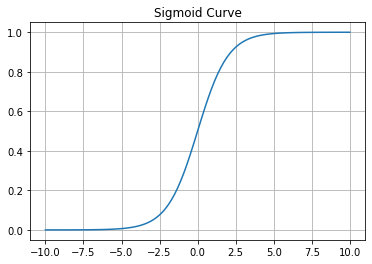

In [4]:
x_s = np.linspace(-10, 10, 100)
plt.figure()
plt.grid()
plt.title('Sigmoid Curve')
plt.plot(x_s, sigmoid(x_s))

As we can see from figure above, the sigmoid curve is limited between 0 and 1. When applied to the output of Linear Regression formula $z=wx+b$, this will effectively limit the output between 0 and 1. This sigmoid activation function output acts as the probability of something classified as TRUE or FALSE. When $\sigma(z) \geq{0.5}$, we can classify the predicted label as TRUE, and when $\sigma(z) < 0.5$, it is classified as FALSE.

Overall flow of logistic regression is pictured below:
<img src="img/logistic-regression-fig.png" width=360 height=360 />

In [8]:
# Logistic regression forward pass
def forward_prop(x, w, b):
    z = np.matmul(w, x) + b
    a = sigmoid(z)
    return a

Next, we will generate some training dataset as the input the logistic regression model. There are 2 inputs to the model $[x_0, x_1]$. Since this is a classification problem, the output $y$ will be $[0, 1]$, and for this notebook, $y$ will be 1 if $x_0 < x_1 $.

In [9]:
# Training input generation
SAMPLE_NM = 1000
x = 10 * np.random.random(size=(2, SAMPLE_NM))
y = np.zeros(shape=(1, SAMPLE_NM))
y[:, x[0, :] < x[1, :]] = 1

Text(0, 0.5, '$x_1$')

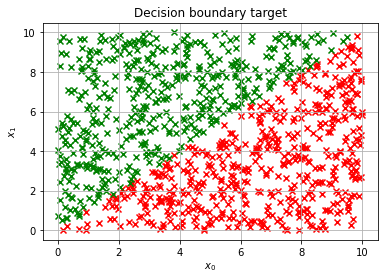

In [10]:
plt.figure()
plt.grid()
plt.title("Target decision boundary")
plt.scatter(x[0, np.argwhere(y == 0)[:, 1]], x[1, np.argwhere(y == 0)[:, 1]], marker='x', c='red')
plt.scatter(x[0, np.argwhere(y == 1)[:, 1]], x[1, np.argwhere(y == 1)[:, 1]], marker='x', c='green')
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")

Figure above represents the decision boundary of classifier that we are going to achieve after training. Green sample represents $y = 1$, and red sample represents $y = 0$

In [11]:
# Initialization
w = np.random.random(size=(1, 2)) - 0.5
b = np.random.random(size=(1, 1)) - 0.5

Initial accuracy: 54.40%


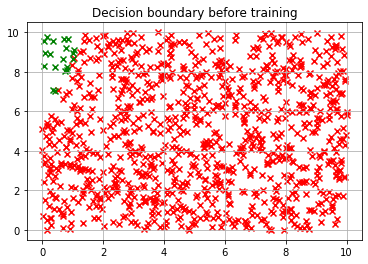

In [12]:
# Initial performance
y_hat = forward_prop(x, w, b)
y_out = np.zeros(shape=y_hat.shape)
y_out[0, y_hat[0, :] >= 0.5] = 1
y_out[0, y_hat[0, :] < 0.5] = 0

plt.figure()
plt.grid()
plt.title("Decision boundary before training")
plt.scatter(x[0, np.argwhere(y_out == 0)[:, 1]], x[1, np.argwhere(y_out == 0)[:, 1]], marker='x', c='red')
plt.scatter(x[0, np.argwhere(y_out == 1)[:, 1]], x[1, np.argwhere(y_out == 1)[:, 1]], marker='x', c='green')

accuracy = np.mean(y_out == y) * 100
print("Initial accuracy: {:.2f}%".format(accuracy))

In [14]:
def compute_cost(x, y, w, b):
    # Forward propagation
    y_hat = forward_prop(x, w, b)
    
    # Using cross-entropy loss function for classification use case
    N = y.shape[1]
    J = 1 / N * np.sum(-y*np.log(y_hat) - (1-y) * np.log(1-y_hat), axis=1)
    return J.item()

In [15]:
# Training
EPOCH_NM = 10000
cost_history = [compute_cost(x, y, w, b)]

for epoch in range(EPOCH_NM):

    # Forward propagation
    y_hat = forward_prop(x, w, b)
    
    # Backward propagation
    N = y.shape[1]
    dJw = 1 / N * np.matmul(y_hat - y, x.T)
    dJb = 1 / N * np.sum(y_hat - y)
    
    # Update weight
    L_RATE = 1e-3
    w = w - L_RATE * dJw
    b = b - L_RATE * dJb
    
    # Check cost
    cost = compute_cost(x, y, w, b)
    cost_history.append(cost)
    
print("Initial cost: {:.6f}".format(cost_history[0]))
print("Final cost: {:.6f}".format(cost_history[-1]))

Initial cost: 0.620088
Final cost: 0.129373
